Matched filtering can be shown to be optimal method for "detecting" known signals in Gaussian Noise. 

In [1]:
import warnings
warnings.filterwarnings("ignore","Wswiglal-redir-stdio")
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# LIGO raw data is sampled at 16384 Hz (=2^14 samples/second).
# It captures signal frequency content up to f_Nyquist = 8192 Hz.
# Here, we will make the computation faster by sampling at a lower rate.
sample_rate = 1024
data_length = 1024
f_nquist = sample_rate/2   # Nyquist frequency: highest frequency that can be captured by the sampling rate

#Generating some random white noise
data = np.random.normal(size=sample_rate*data_length)
times = np.arange(len(data))/sample_rate

In [3]:
# Now, adding thee GW data in the above noise signal
from pycbc.waveform import get_td_waveform
# the "approximant" (jargon for parameterized waveform family).
# IMRPhenomD(a phenomenological Inspiral–Merger–Ringdown wafeform model) is defined in the frequency domain, but we'll get it in the time domain (td).
# It runs fast, but it doesn't include effects such as non-aligned component spin, or higher order modes.
apx = 'IMRPhenomD'

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [4]:
# We will be using only the plus polarization.
hp1, _ = get_td_waveform(approximant=apx, mass1=10, mass2=10, delta_t=1.0/sample_rate, f_lower=25)

In [5]:
# Normalizing the hp1, so that cross-correlation of the signal gives us 1
hp1 = hp1/max(np.correlate(hp1,hp1,mode='full'))**0.5

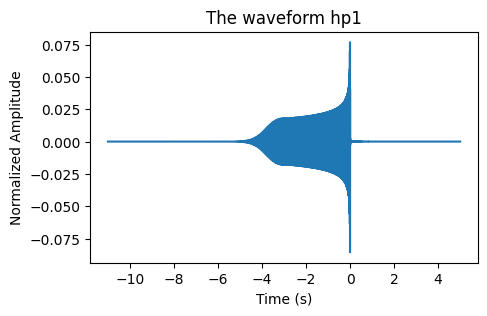

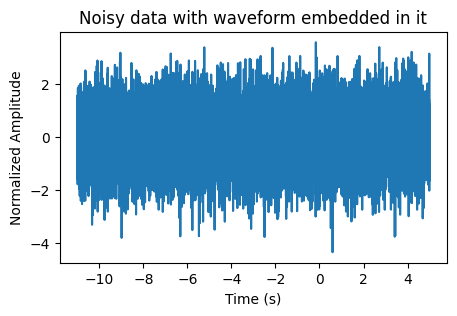

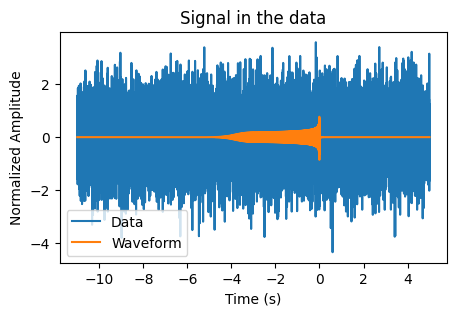

In [6]:
plt.figure(figsize=(5,3))
plt.plot(hp1.sample_times,hp1)
plt.title('The waveform hp1')
plt.xlabel('Time (s)')
plt.ylabel("Normalized Amplitude")

# Shifting the waveform to start at a random time in Gaussian noise data
waveform_start = np.random.randint(0,len(data)-len(hp1))
data[waveform_start:waveform_start+len(hp1)] += 10*hp1.numpy()

plt.figure(figsize=(5,3))
plt.title('Noisy data with waveform embedded in it')
plt.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Amplitude')

plt.figure(figsize=(5,3))
plt.title("Signal in the data")
plt.xlabel('Time (s)')
plt.ylabel('Normalized Amplitude')
plt.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
plt.plot(hp1.sample_times, 10*hp1)
plt.legend(['Data', 'Waveform'])
plt.show()

Now, our task it to search for the signal in the noisy data.\
One approach can be to calculate cross-correlation of the signal and the entire dataset.\
But this method is slow to compute.

In [7]:
cross_correlation = np.zeros([len(data)-len(hp1)])
hp1_numpy = hp1.numpy()
for i in range (len(data)-len(hp1)):
    cross_correlation[i] = (hp1_numpy*data[i:i+len(hp1)]).sum()

Compute the above correlation using numpy.correlate

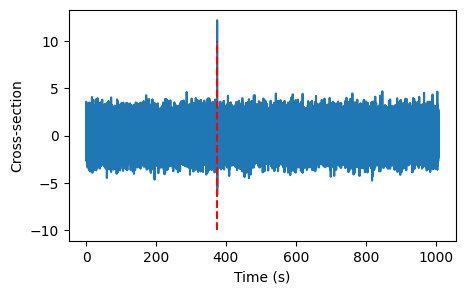

In [8]:
# plot the cross-correlated data vs time. Superimpose the location of the end of the signal;
# this is where we should find a peak in the cross-correlation.
plt.figure(figsize=(5,3))
times = np.arange(len(data)-len(hp1))/float(sample_rate)
plt.plot(times, cross_correlation)
plt.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)], [-10,10], '--r')
plt.xlabel('Time (s)')
plt.ylabel('Cross-section')
plt.show()

As we can see in the plot above that the peak in correlation coincides with the point where the waveform starts or the signal starts.

# Detection in coloured noise

- By coloured noise, we mean such noise which has frequency dependent variance. OR in other words, the power distribution of the noise signal across different frequencies is not uniform or dependent of the frequency.
- We will now repeat the process that we did above but now,
we will generate a stretch of data colored with LIGO's zero-detuned--high-power noise curve.

In [9]:
import pycbc.noise
import pycbc.psd

# What is Zero-detuned--high power noise curve??
- Detuning means shifting the resonance frequency of the interferometer's optical cavities from their optimal point.
- Zero-detuned means that cavities are tuned to resonate at their designed frequencies (maximum constructive interference).
- Noise curve: Plot of the senstivity of the detector as a function of frequency. Represents the minimum strain detectable at a particular frequency.
- High power is used to mitigate the shot noise.

In [10]:
# The color of the noise matches a PSD which you provide:
# Generate a PSD matching Advanced LIGO's zero-detuned--high-power noise curve
flow = 10
delta_f = 1/128
flen = int(f_nquist/delta_f)+1
psd = pycbc.psd.aLIGOZeroDetHighPower(length=flen, delta_f=delta_f, low_freq_cutoff=flow)

# Generate some colored noise
delta_t = 1/sample_rate
ts = pycbc.noise.noise_from_psd(length=data_length*sample_rate,delta_t=delta_t,psd=psd, seed=127)

In [11]:
# Estimate the ASD for the noisy data using the Welch's method.
# We will use 4 seconds PSD samples that are overlapped 50%.
seg_len = int(4/delta_t)
seg_stride = int(seg_len/2)
estimated_psd = pycbc.psd.welch(seg_len=seg_len, seg_stride=seg_stride,timeseries=ts)

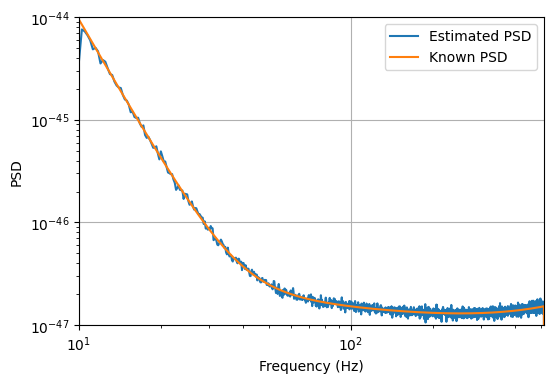

In [12]:
# plotting it
plt.figure(figsize=(6,4))
plt.loglog(estimated_psd.sample_frequencies, estimated_psd, label='Estimated PSD')
plt.loglog(psd.sample_frequencies,psd, label='Known PSD')
plt.xlim(flow, f_nquist)
plt.ylim(1e-47, 1e-44)
plt.xlabel('Frequency (Hz)')
plt.ylabel("PSD")
plt.legend()
plt.grid()
plt.show()

In [13]:
# Add the simulated gravitational wave signal 
ts[waveform_start:waveform_start+len(hp1)] += hp1.numpy()*1e-20

# Data Whitening
- Now, we need to "whiten" the data. "Whitening" means removing the frequency-dependent variations in the power of the signal so that all frequencies have equal power (removing the color).
- This can be done in both time domain and frequency domain but is a lot more intuitive in the frequency domain.

### Why is this necessary?

In [14]:
# Generating a PSD which can be used to whiten the data
from pycbc.types import TimeSeries

# The PSD, sampled properly for the noisy data
delta_f = 1/data_length
flen = int(f_nquist/delta_f)+1
psd_td = pycbc.psd.aLIGOZeroDetHighPower(length=flen, delta_f=delta_f, low_freq_cutoff=0)

# The PSD, sampled properly for the signal
delta_f = sample_rate/float(len(hp1))
flen = int(f_nquist/delta_f)+1
psd_hp1 = pycbc.psd.aLIGOZeroDetHighPower(length=flen, delta_f=delta_f, low_freq_cutoff=0)

# The 0th and Nth values are zero. Set them to a nearby value to avoid dividing by zero
psd_td[0] = psd_td[1]
psd_td[len(psd_td)-1] = psd_td[len(psd_td)-2]
psd_hp1[0] = psd_hp1[1]
psd_hp1[len(psd_hp1)-1] = psd_hp1[len(psd_hp1)-2]

To whiten the data:
- Convert both noisy and the signal data to frequency domain.
- Divide each by ASD ($\sqrt{PSD}$)
- Then convert back to time domain.

In [15]:
data_whitened = (ts.to_frequencyseries()/psd_td**0.5).to_timeseries()
hp1_whitened = (hp1.to_frequencyseries()/psd_hp1**0.5).to_timeseries()

In [16]:
# Now, lets perform the correlation again but with the whitened data and template
cross_correlation = np.zeros([len(data)-len(hp1)])
hp1n = hp1_whitened.numpy()
datan = data_whitened.numpy()
for i in range(len(data)-len(hp1)):
    cross_correlation[i] = (hp1n*datan[i:i+len(hp1n)]).sum()

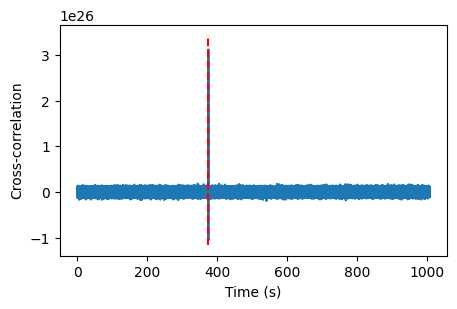

In [17]:
#Plotting the cross-correlation in the time domain.
# Superimpose the location of the end of the signal.
plt.figure(figsize=(5,3))
times = np.arange(len(data)-len(hp1))/float(sample_rate)
plt.plot(times,cross_correlation)
plt.plot([waveform_start/float(sample_rate),waveform_start/float(sample_rate)],
         [min(cross_correlation)*1.1, max(cross_correlation)*1.1], '--r')
plt.xlabel("Time (s)")
plt.ylabel("Cross-correlation")
plt.show()

# Challenges

1. Histogram the whitened time series. Ignoring the outliers associated with the signal, is it a Gaussian? What is the mean and standard deviation? (We have not been careful in normalizing the whitened data properly).

Mean of the whitened data: 2.340575649961707e-15
Standard deviation of the whitened data: 22.479917173656414


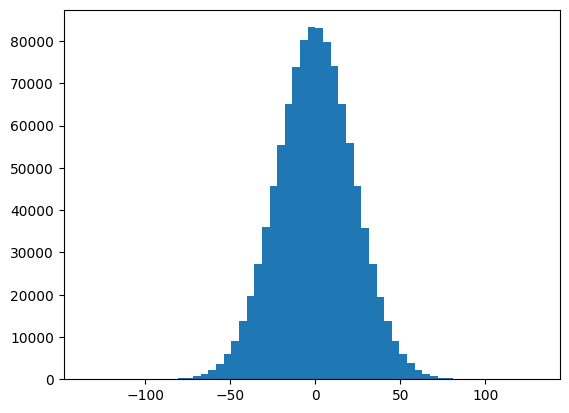

In [29]:
datastd = data_whitened.data.std()
datamean = data_whitened.data.mean()
print("Mean of the whitened data:", datamean)
print("Standard deviation of the whitened data:",datastd)
plt.hist(data_whitened.data,bins=np.arange(-6,6,0.2)*datastd)
plt.show()

2. Histogram the above cross-correlation time series. Ignoring the outliers associated with the signal, is it a Gaussian? What is the mean and standard deviation?

Std. deviation: 3.992212694519385e+24
Mean: -6.494026815117106e+18


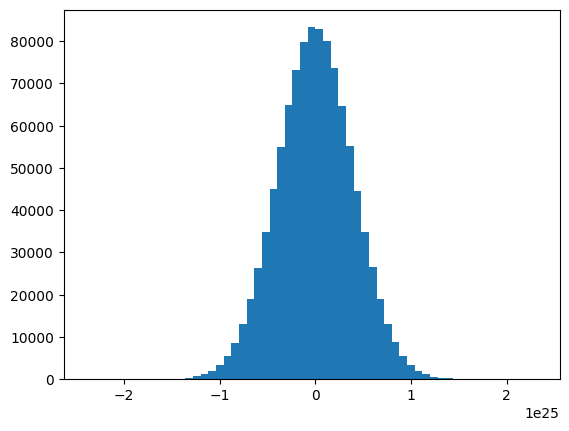

In [33]:
crossstd = cross_correlation.std()
crossmean = cross_correlation.mean()
print("Std. deviation:", crossstd)
print("Mean:", crossmean)
plt.hist(cross_correlation,bins=np.arange(-6,6,0.2)*crossstd)
plt.show()

3. (Optional) Find the location of the peak. (Note that here, it can be positive or negative), and the value of the SNR of the signal (which is the absolute value of the peak value, divided by the standard deviation of the cross-correlation time series).